In [72]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd

In [74]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1'])
    y1 = h['r1']*np.sin(h['phi1'])
    x2 = h['r2']*np.cos(h['phi2'])
    y2 = h['r2']*np.sin(h['phi2'])
    x3 = h['r3']*np.cos(h['phi3'])
    y3 = h['r3']*np.sin(h['phi3'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [75]:
def deltaphi(a,b,ch) :
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)

In [76]:
def alignRZ(h, ptmin) :
    ri = h['r1']
    zi = h['z1']
    rm = h['r2']
    zm = h['z2']
    ro = h['r3']
    zo = h['z3']
    radius_diff = abs(rm - ro)
    distance_13_squared = radius_diff*radius_diff + (zm - zo)*(zm - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = abs(zm * (ri - ro) + zi * (ro - rm) + zo * (rm - ri)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [77]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [78]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [79]:
file = '/Users/innocent/data/pixHits.csv'
hits = pd.read_csv(file, delimiter=" ")
print '#hits', len(hits)
hits['seq'] = hits['layer'] + 4*(1-hits['isBarrel'])
hits.sort_values(by=['trackID','r'],inplace=True)
print hits


#hits 215189
         trackID         pt         r          z       phi  isBarrel  layer  \
0         100005   3.678140   5.12146 -49.354400 -2.096770         0      3   
1         100005   3.861860   5.20585 -50.212700 -2.095470         0      3   
2         100008   7.832590   2.74098  -9.934890  0.763388         1      1   
3         100009   2.868140   6.83510 -49.379200  1.950560         0      3   
4         100010   0.947519   6.59820 -26.476900 -2.260330         1      2   
5         100010   0.545019   8.24116 -33.226400 -2.302030         0      1   
6         100010   0.543727   8.28708 -33.424700 -2.303120         0      1   
7         100010   0.551949  10.18970 -41.332200 -2.350670         0      2   
8         100010   0.441951  11.72140 -47.758500 -2.389210         0      3   
9         100010   0.441101  11.76470 -47.945000 -2.390430         0      3   
10        100011   1.449360   3.29424  -8.165910  1.220370         1      1   
11        100011   1.447880  10.73060 -

43590 35339 26992 20756 30590 29609 28313


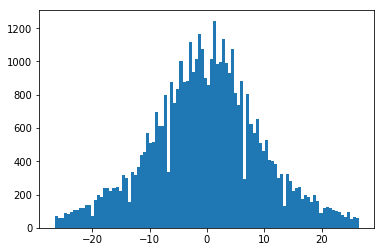

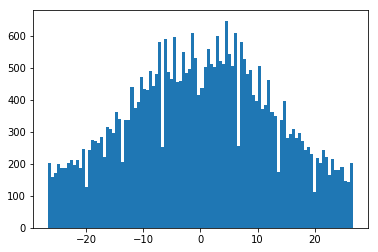

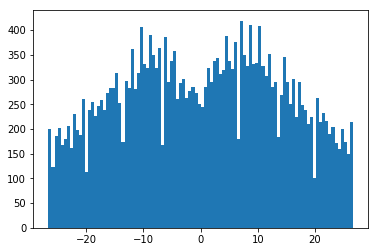

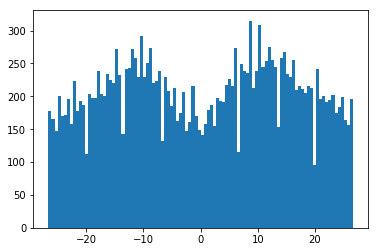

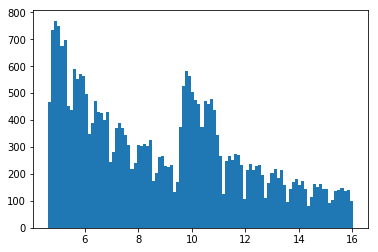

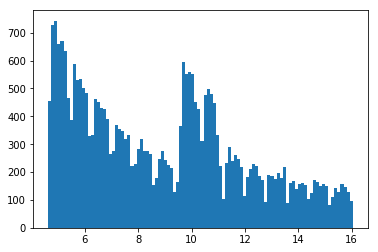

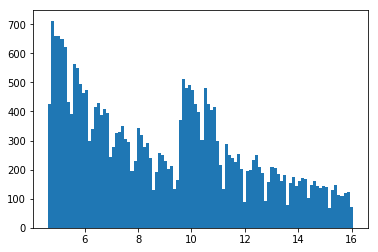

In [80]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5')
hf2 = hits.query('seq==6')
hf3 = hits.query('seq==7')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['z'],log=False, bins=100)
plt.show()
plt.hist(hb2['z'],log=False, bins=100)
plt.show()
plt.hist(hb3['z'],log=False, bins=100)
plt.show()
plt.hist(hb4['z'],log=False, bins=100)
plt.show()
plt.hist(hf1['r'],log=False, bins=100)
plt.show()
plt.hist(hf2['r'],log=False, bins=100)
plt.show()
plt.hist(hf3['r'],log=False, bins=100)
plt.show()


In [81]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
      trackID          pt        r        z      phi  isBarrel  layer  seq
min    100008    0.200016  2.73801 -26.5552 -3.14015         1      1    1
max  51400388  670.706000  3.37240  26.5451  3.14133         1      1    1
      trackID          pt        r        z      phi  isBarrel  layer  seq
min    100010    0.200001  6.57456 -26.6130 -3.14109         1      2    2
max  51400342  347.918000  7.25012  26.6059  3.14144         1      2    2
      trackID          pt        r        z      phi  isBarrel  layer  seq
min    100011    0.200049  10.7044 -26.6243 -3.14153         1      3    3
max  51400341  353.729000  11.3355  26.6347  3.14136         1      3    3
      trackID          pt        r        z      phi  isBarrel  layer  seq
min    100014    0.200053  15.7995 -26.6360 -3.14149         1      4    4
max  51400342  353.748000  16.4585  26.6326  3.14108         1      4    4
      trackID          pt         r        z      phi  isBarrel  layer  seq
min    100010   

In [82]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['z'],
                    'r'+n : hh['r'],
                    'phi'+n : hh['phi'],
                    'pt'+n : hh['pt'],
                    'trackID' : hh['trackID']
                       })


In [83]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)

11588
2128
7426
21593
42735


In [84]:
def plot(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  print 'delta'
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()
    
  thcut = alignRZ(quadc,0.6)
  curv = curvature(quadc,0.6,0.2,0.2)
  rad = curvature(quadc,0.6,0.2,0.2,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut',len(thcut)
  plt.hist(thcut[thcut<0.1],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

  print 'dphi'
  d1 = quadc['phi1']-quadc['phi2']
  plt.hist(d1[abs(d1)<0.3], bins=100,log=True)
  plt.show()
  d2 = quadc['phi2']-quadc['phi3']
  plt.hist(d2[abs(d2)<0.3], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<0.3], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z1']-quadc['z2']
  plt.hist(d1[abs(d1)<30], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']-quadc['z3']
  plt.hist(d2[abs(d2)<30], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[abs(d3)<30], bins=100,log=True)
  plt.show()

  print 'dr'
  d1 = quadc['r1']-quadc['r2']
  plt.hist(d1[abs(d1)<20], bins=100,log=True)
  plt.show()
  d2 = quadc['r2']-quadc['r3']
  plt.hist(d2[abs(d2)<20], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[abs(d3)<20], bins=100,log=True)
  plt.show()



delta
field


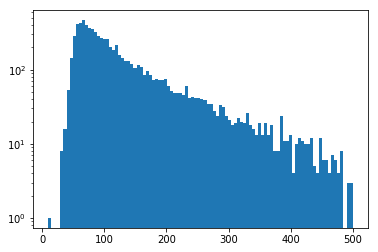

thcut 8101


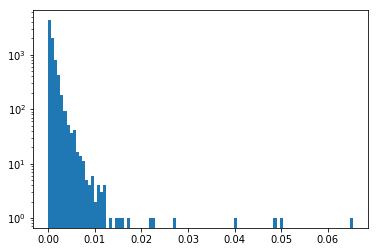

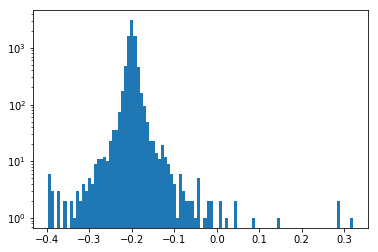

dphi


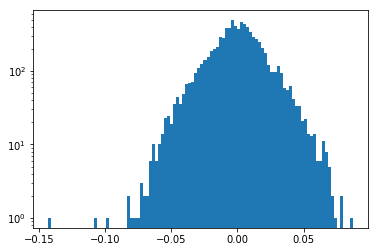

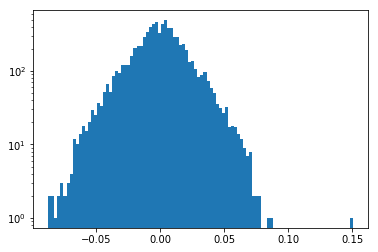

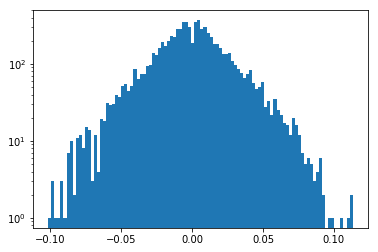

dz


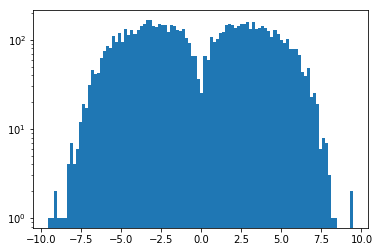

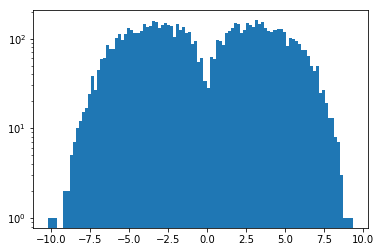

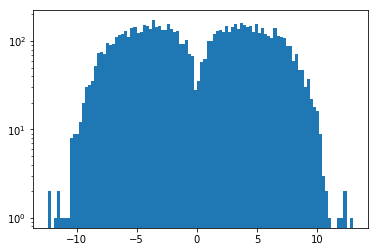

dr


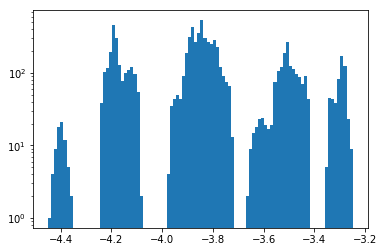

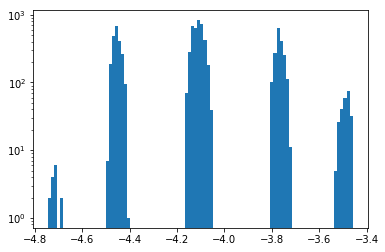

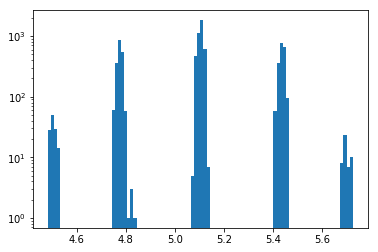

delta
field


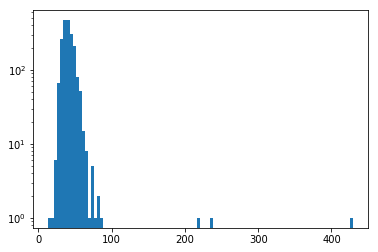

thcut 1961


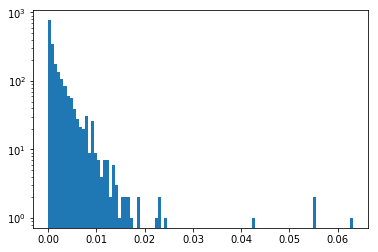

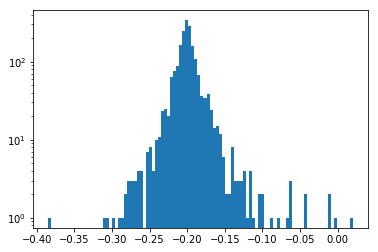

dphi


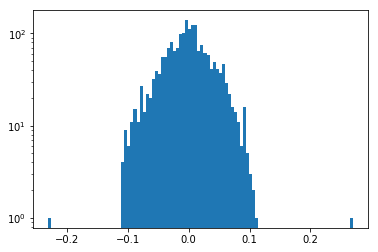

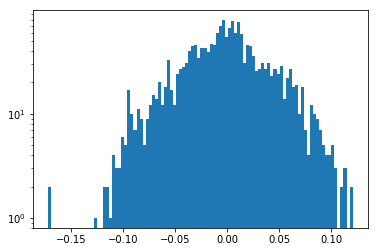

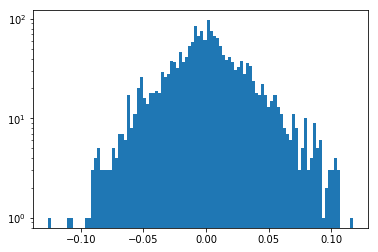

dz


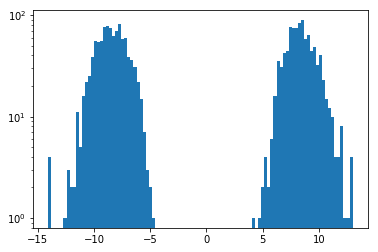

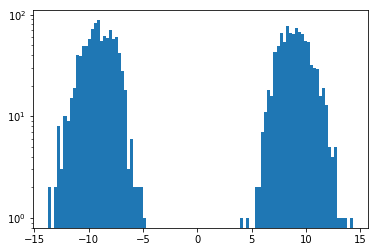

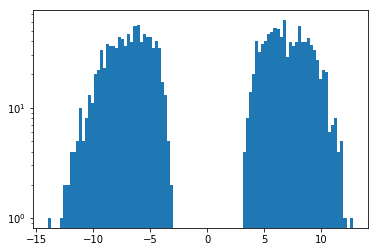

dr


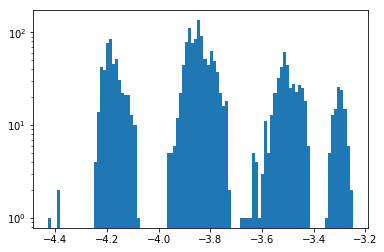

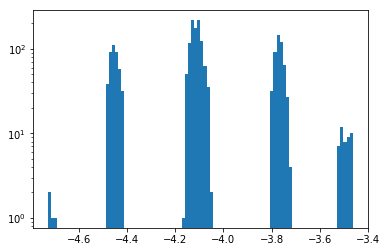

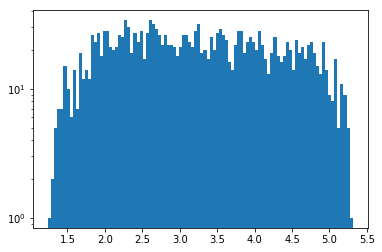

delta
field


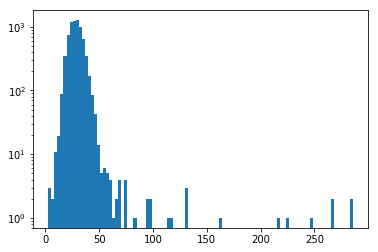

thcut 7224


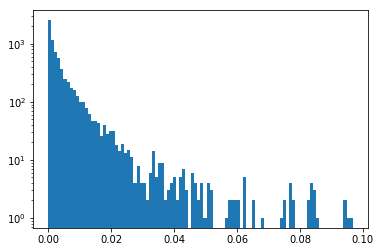

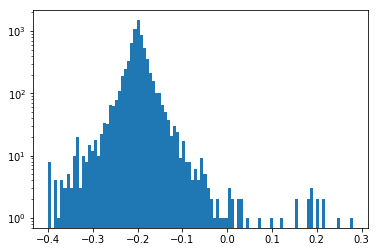

dphi


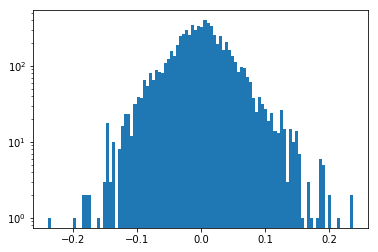

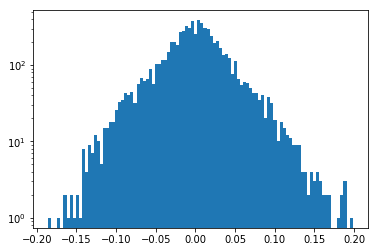

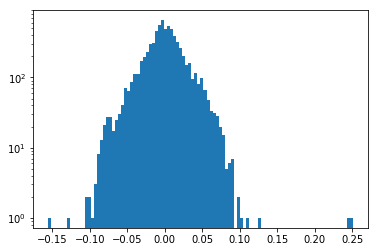

dz


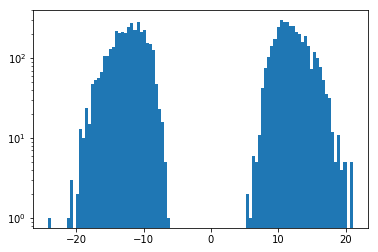

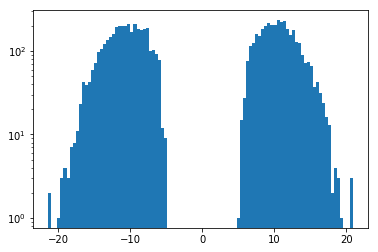

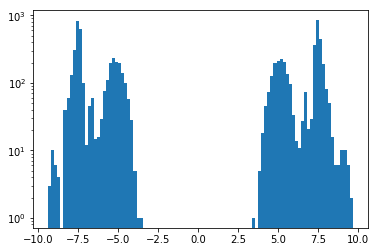

dr


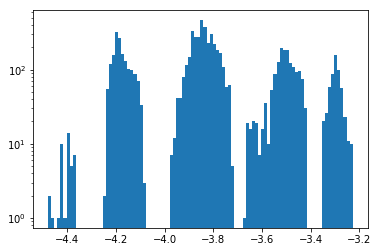

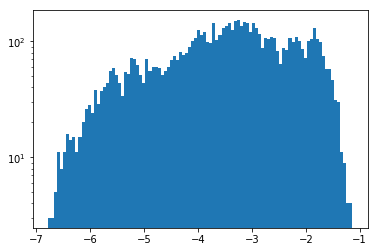

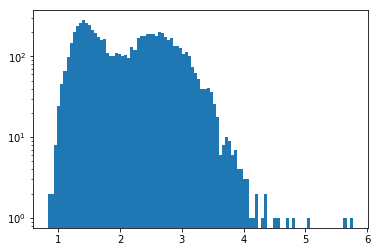

delta
field


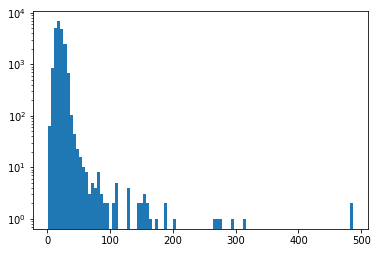

thcut 21357


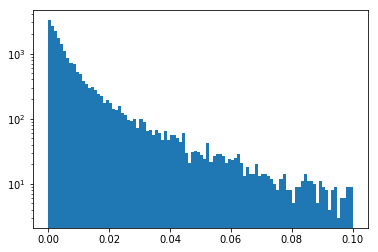

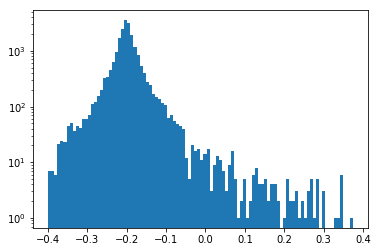

dphi


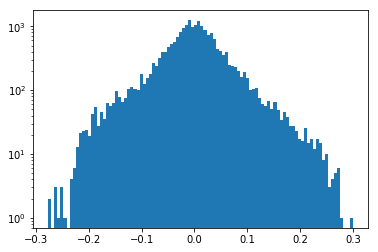

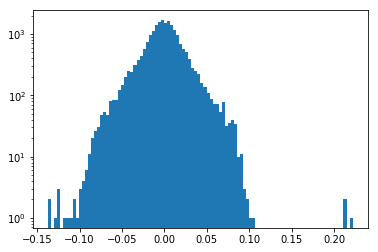

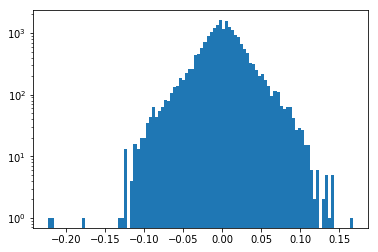

dz


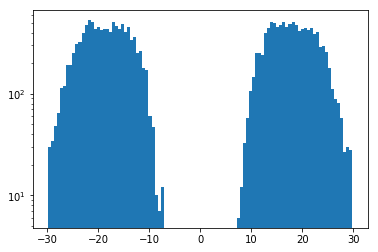

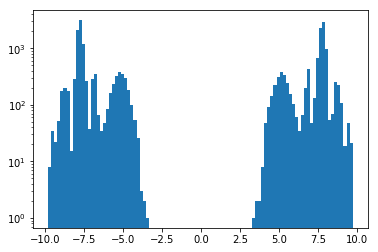

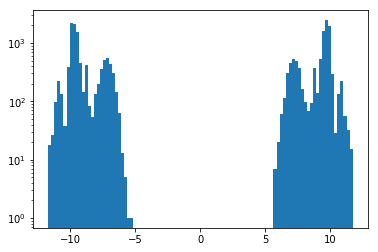

dr


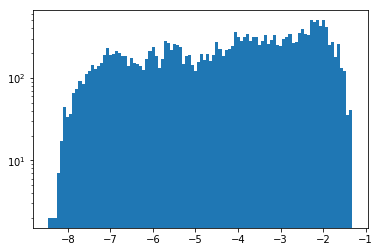

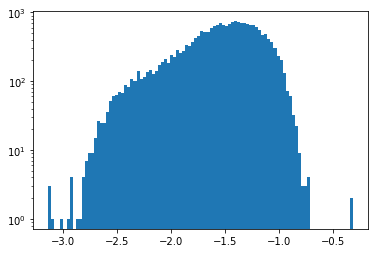

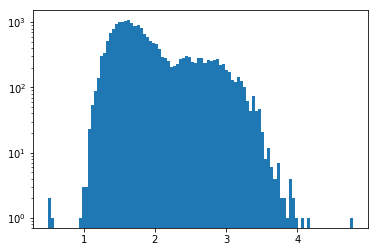

In [85]:
for quad in [t1234,t1231,t1212,t1123] :
  plot(quad,0.5)